# Project Title
### Data Engineering Capstone Project

#### Project Summary
This project has a Modeling, pipelines, quality and warehouse data with python and spark.
This project will pull data from all sources and create fact and dimension tables to show movement of immigration in US.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [100]:
# Do all imports and installs here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import re

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
spark = SparkSession.builder\
                     .config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
                     .config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
                     .getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
The main dataset will include data on immigration to the United States, and supplementary datasets will include data on airport codes, U.S. city demographics, and temperature data. You're also welcome to enrich the project with additional data if you'd like to set your project apart.

#### Describe and Gather Data 
- I94 Immigration Data: This data comes from the US National Tourism and Trade Office. A data dictionary is included in the workspace. This is where the data comes from. There's a sample file so you can take a look at the data in csv format before reading it all in. You do not have to use the entire dataset, just use what you need to accomplish the goal you set at the beginning of the project.
- World Temperature Data: This dataset came from Kaggle. You can read more about it here.
- U.S. City Demographic Data: This data comes from OpenSoft. You can read more about it here.
- Airport Code Table: This is a simple table of airport codes and corresponding cities. It comes from here.

### Airport Codes

In [24]:
# Read in the data here
df_airport = pd.read_csv("airport-codes_csv.csv")

In [25]:
df_airport.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [5]:
df_airport.shape

(55075, 12)

### Immigration Data

In [6]:
df_immigration = pd.read_csv("immigration_data_sample.csv")

In [7]:
df_immigration.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,20573.0,61.0,2.0,1.0,20160422,NaN,NaN,G,O,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,20568.0,26.0,2.0,1.0,20160423,MTR,NaN,G,R,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,20571.0,76.0,2.0,1.0,20160407,NaN,NaN,G,O,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,20581.0,25.0,2.0,1.0,20160428,DOH,NaN,G,O,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,20553.0,19.0,2.0,1.0,20160406,NaN,NaN,Z,K,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


In [8]:
df_immigration.shape

(1000, 29)

### US Cities Demographics

In [33]:
df_demographics = pd.read_csv("us-cities-demographics.csv", sep=';')

In [34]:
df_demographics.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [11]:
df_demographics.shape

(2891, 12)

### Global Land Temperatures By City

In [18]:
df_globaltemp = pd.read_csv('../../data2/GlobalLandTemperaturesByCity.csv')

In [25]:
df_globaltemp.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [26]:
df_globaltemp.shape

(8599212, 7)

### I94 Immigration dataset

In [7]:
#df_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
#write to parquet
#df_spark.write.parquet("sas_data")
df_I94_SAS=spark.read.parquet("sas_data")

In [8]:
df_I94_SAS.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,40.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,32.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,28.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1


In [10]:
df_I94_SAS.count(), len(df_I94_SAS.columns)

(3096313, 28)

### I94 SAS Labels Descriptions

In [43]:
with open("I94_SAS_Labels_Descriptions.SAS") as f:
    content = f.readlines()

In [45]:
content = [x.strip() for x in content]

In [50]:
ports = content[302:962]

In [57]:
regex = re.compile(r"\'(.*)\'.*\'(.*)\'")

In [79]:
city_ports = []

In [83]:
for port in ports:
    results = regex.search(port)
    port_code = results.group(1)
    port_city = results.group(2).split(',')[0]
    port_state = results.group(2).split(',')[-1]
    city_ports.append([port_code, port_city, port_state])

In [91]:
df_ports = pd.DataFrame(city_ports, columns=['port_code', 'port_city', 'port_state'])

In [92]:
df_ports.head()

,port_code,port_city,port_state
0,ALC,ALCAN,AK
1,ALC,ALCAN,AK
2,ANC,ANCHORAGE,AK
3,BAR,BAKER AAF - BAKER ISLAND,AK
4,DAC,DALTONS CACHE,AK


In [93]:
df_ports.shape

(661, 3)

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

### Airport Codes

In [12]:
df_airport.dtypes

ident            object
type             object
name             object
elevation_ft    float64
continent        object
iso_country      object
iso_region       object
municipality     object
gps_code         object
iata_code        object
local_code       object
coordinates      object
dtype: object

In [13]:
df_airport.describe()

,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


In [28]:
df_airport.dropna(subset=['iata_code'], inplace=True)

### Immigration Data

In [14]:
df_immigration.dtypes

Unnamed: 0      int64
cicid         float64
i94yr         float64
i94mon        float64
i94cit        float64
i94res        float64
i94port        object
arrdate       float64
i94mode       float64
i94addr        object
depdate       float64
i94bir        float64
i94visa       float64
count         float64
dtadfile        int64
visapost       object
occup          object
entdepa        object
entdepd        object
entdepu       float64
matflag        object
biryear       float64
dtaddto        object
gender         object
insnum        float64
airline        object
admnum        float64
fltno          object
visatype       object
dtype: object

In [15]:
df_immigration.describe()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,arrdate,i94mode,depdate,i94bir,i94visa,count,dtadfile,entdepu,biryear,insnum,admnum
count,1.000000e+03,1.000000e+03,1000.0,1000.0,1000.000000,1000.00000,1000.000000,1000.000000,951.000000,1000.000000,1000.000000,1000.0,1.000000e+03,0.0,1000.000000,35.000000,1.000000e+03
mean,1.542097e+06,3.040461e+06,2016.0,4.0,302.928000,298.26200,20559.680000,1.078000,20575.037855,42.382000,1.859000,1.0,2.016042e+07,NaN,1973.618000,3826.857143,6.937237e+10
std,9.152879e+05,1.799818e+06,0.0,0.0,206.485285,202.12039,8.995027,0.485955,24.211234,17.903424,0.386353,0.0,4.951657e+01,NaN,17.903424,221.742583,2.338134e+10
min,1.092500e+04,1.320800e+04,2016.0,4.0,103.000000,103.00000,20545.000000,1.000000,20547.000000,1.000000,1.000000,1.0,2.016040e+07,NaN,1923.000000,3468.000000,0.000000e+00
25%,7.214422e+05,1.412170e+06,2016.0,4.0,135.000000,131.00000,20552.000000,1.000000,20561.000000,30.750000,2.000000,1.0,2.016041e+07,NaN,1961.000000,3668.000000,5.599301e+10
50%,1.494568e+06,2.941176e+06,2016.0,4.0,213.000000,213.00000,20560.000000,1.000000,20570.000000,42.000000,2.000000,1.0,2.016042e+07,NaN,1974.000000,3887.000000,5.931477e+10
75%,2.360901e+06,4.694151e+06,2016.0,4.0,438.000000,438.00000,20567.250000,1.000000,20580.000000,55.000000,2.000000,1.0,2.016042e+07,NaN,1985.250000,3943.000000,9.343623e+10
max,3.095749e+06,6.061994e+06,2016.0,4.0,746.000000,696.00000,20574.000000,9.000000,20715.000000,93.000000,3.000000,1.0,2.016080e+07,NaN,2015.000000,4686.000000,9.502151e+10


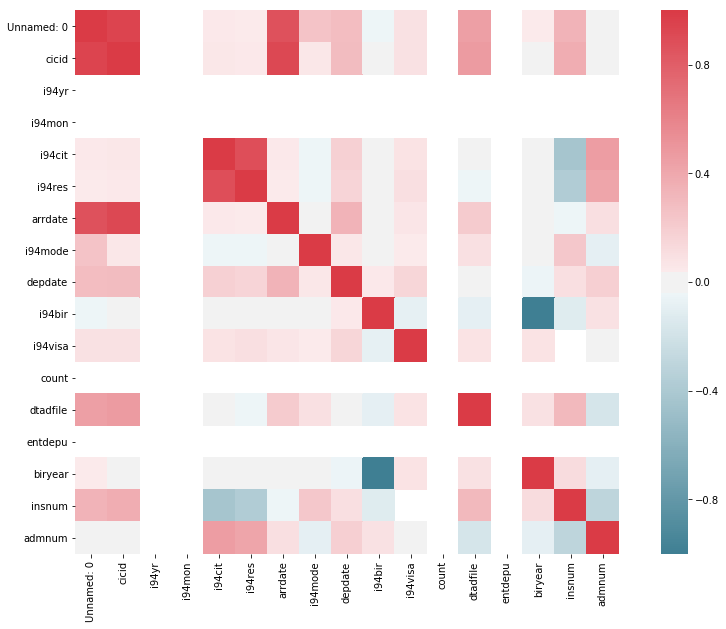

In [16]:
f, ax = plt.subplots(figsize=(15, 10))
corr = df_immigration.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

### US Cities Demographics

In [17]:
df_demographics.dtypes

City                       object
State                      object
Median Age                float64
Male Population           float64
Female Population         float64
Total Population            int64
Number of Veterans        float64
Foreign-born              float64
Average Household Size    float64
State Code                 object
Race                       object
Count                       int64
dtype: object

In [18]:
df_demographics.describe()

,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,Count
count,2891.000000,2.888000e+03,2.888000e+03,2.891000e+03,2878.000000,2.878000e+03,2875.000000,2.891000e+03
mean,35.494881,9.732843e+04,1.017696e+05,1.989668e+05,9367.832523,4.065360e+04,2.742543,4.896377e+04
std,4.401617,2.162999e+05,2.315646e+05,4.475559e+05,13211.219924,1.557491e+05,0.433291,1.443856e+05
min,22.900000,2.928100e+04,2.734800e+04,6.321500e+04,416.000000,8.610000e+02,2.000000,9.800000e+01
25%,32.800000,3.928900e+04,4.122700e+04,8.042900e+04,3739.000000,9.224000e+03,2.430000,3.435000e+03
50%,35.300000,5.234100e+04,5.380900e+04,1.067820e+05,5397.000000,1.882200e+04,2.650000,1.378000e+04
75%,38.000000,8.664175e+04,8.960400e+04,1.752320e+05,9368.000000,3.397175e+04,2.950000,5.444700e+04
max,70.500000,4.081698e+06,4.468707e+06,8.550405e+06,156961.000000,3.212500e+06,4.980000,3.835726e+06


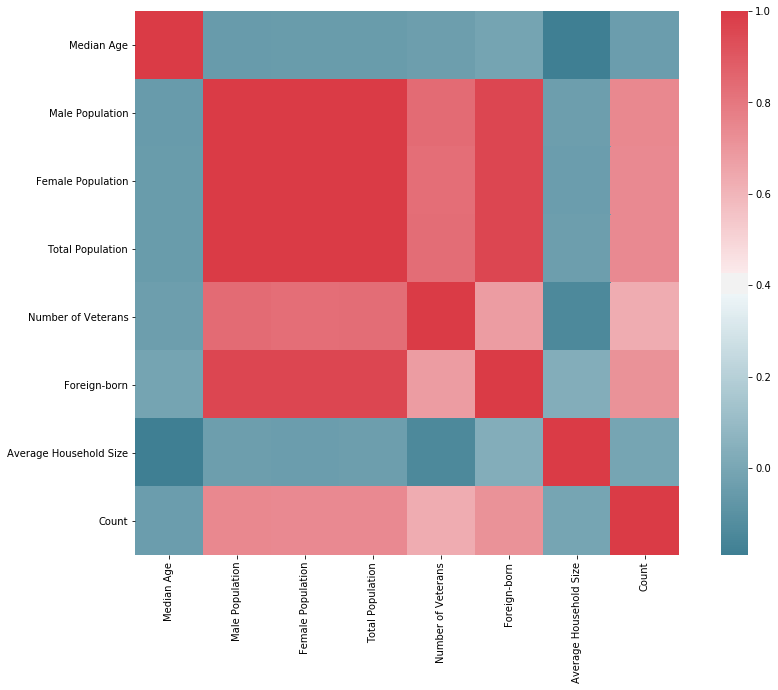

In [19]:
f, ax = plt.subplots(figsize=(15, 10))
corr = df_demographics.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

### Global Land Temperatures By City

In [19]:
df_globaltemp.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

In [20]:
df_globaltemp.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


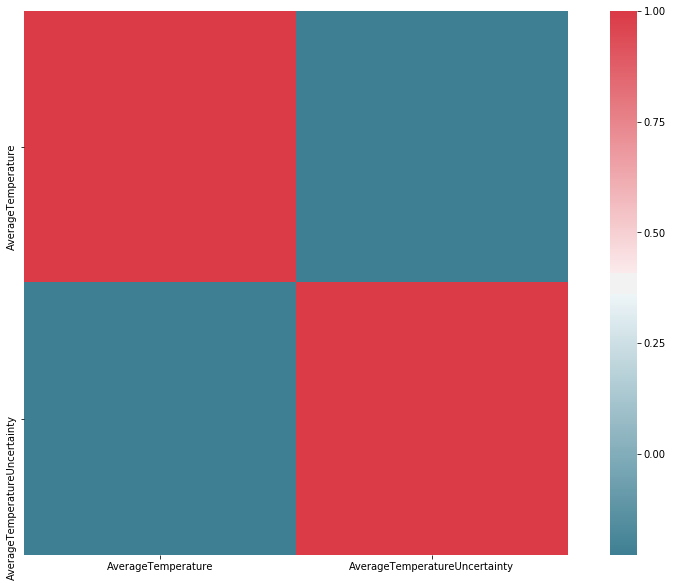

In [21]:
f, ax = plt.subplots(figsize=(15, 10))
corr = df_globaltemp.corr()
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True, ax=ax)

In [41]:
df_globaltemp = df_globaltemp[df_globaltemp["Country"] == "United States"]

### I94 SAS Labels Descriptions

In [11]:
df_I94_SAS.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [12]:
df_I94_SAS.describe().toPandas()

,summary,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,count,3096313,3096313,3096313,3096313,3096313,3096313,3096313,3096074,2943721,2953856,3095511,3096313,3096313,3096312,1215063,8126,3096075,2957884,392,2957884,3095511,3095836,2682044,113708,3012686,3096313,3076764,3096313
1,mean,3078651.879075533,2016.0,4.0,304.9069344733559,303.28381949757664,None,20559.84854179794,1.0736897761487614,51.652482269503544,20573.95283554784,41.767614458485205,1.8453925685161674,1.0,2.0160424766168267E7,999.0,885.675,None,None,None,None,1974.2323855415148,8291120.333841449,None,4131.050016327899,59.477601493233784,7.082885011150484E10,1360.2463696420555,None
2,stddev,1763278.0997499449,0.0,0.0,210.02688853063205,208.58321292789535,None,8.777339475317723,0.5158963131657106,42.97906231370983,29.35696848166157,17.42026053458727,0.3983910200540999,0.0,50.01513453988029,0.0,264.6551105950961,None,None,None,None,17.420260534589556,1656502.4244925722,None,8821.743471773654,172.6333995206175,2.2154415947558968E10,5852.676345633695,None
3,min,6.0,2016.0,4.0,101.0,101.0,5KE,20545.0,1.0,..,15176.0,-3.0,1.0,1.0,20130811,999,049,A,D,U,M,1902.0,/ 183D,F,0,*FF,0.0,00000,B1
4,max,6102785.0,2016.0,4.0,999.0,760.0,YSL,20574.0,9.0,ZU,45427.0,114.0,3.0,1.0,20160919,ZZZ,WTR,Z,W,Y,M,2019.0,D/S,X,YM0167,ZZ,9.991556593E10,ZZZ,WT


In [13]:
df_I94_SAS.summary().toPandas()

,summary,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,count,3096313,3096313,3096313,3096313,3096313,3096313,3096313,3096074,2943721,2953856,3095511,3096313,3096313,3096312,1215063,8126,3096075,2957884,392,2957884,3095511,3095836,2682044,113708,3012686,3096313,3076764,3096313
1,mean,3078651.879075533,2016.0,4.0,304.9069344733559,303.28381949757664,None,20559.84854179794,1.0736897761487614,51.652482269503544,20573.95283554784,41.767614458485205,1.8453925685161674,1.0,2.0160424766168267E7,999.0,885.675,None,None,None,None,1974.2323855415148,8291120.333841449,None,4131.050016327899,59.477601493233784,7.082885011150484E10,1360.2463696420555,None
2,stddev,1763278.0997499449,0.0,0.0,210.02688853063205,208.58321292789535,None,8.777339475317723,0.5158963131657106,42.97906231370983,29.35696848166157,17.42026053458727,0.3983910200540999,0.0,50.01513453988029,0.0,264.6551105950961,None,None,None,None,17.420260534589556,1656502.4244925722,None,8821.743471773654,172.6333995206175,2.2154415947558968E10,5852.676345633695,None
3,min,6.0,2016.0,4.0,101.0,101.0,5KE,20545.0,1.0,..,15176.0,-3.0,1.0,1.0,20130811,999,049,A,D,U,M,1902.0,/ 183D,F,0,*FF,0.0,00000,B1
4,25%,1577480.0,2016.0,4.0,135.0,131.0,None,20552.0,1.0,10.0,20561.0,30.0,2.0,1.0,2.0160409E7,999.0,855.0,None,None,None,None,1962.0,7102016.0,None,3680.0,2.0,5.6035214733E10,101.0,None
5,50%,3103635.0,2016.0,4.0,213.0,213.0,None,20560.0,1.0,40.0,20570.0,41.0,2.0,1.0,2.0160417E7,999.0,999.0,None,None,None,None,1975.0,7252016.0,None,3872.0,2.0,5.9360818033E10,408.0,None
6,75%,4654348.0,2016.0,4.0,512.0,504.0,None,20567.0,1.0,99.0,20579.0,54.0,2.0,1.0,2.0160424E7,999.0,999.0,None,None,None,None,1986.0,1.0132016E7,None,3945.0,2.0,9.350985333E10,903.0,None
7,max,6102785.0,2016.0,4.0,999.0,760.0,YSL,20574.0,9.0,ZU,45427.0,114.0,3.0,1.0,20160919,ZZZ,WTR,Z,W,Y,M,2019.0,D/S,X,YM0167,ZZ,9.991556593E10,ZZZ,WT


In [14]:
df_I94_SAS.select("visapost").dropDuplicates().count()

531

In [15]:
# drop duplicate cicid
df_I94_SAS = df_I94_SAS.dropDuplicates(['cicid'])

In [16]:
# drop rows with missing
df_I94_SAS = df_I94_SAS.dropna(how='all', subset=['cicid'])

### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model

- DIMENSIONS:
 - DIM AIRPORTS - iata_code, name, type, local_code, iso_country, municipality, coordinates, port_city
 - DIM DEMOGRAPHICS - City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,StateCode,Race,Count
 - DIM TEMPERATURE - dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
- FACTS:
 - FACT IMMIGRATIONS - cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype 

#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

- Merge dataframe AIRPORT with PORTS on iata_code and port_code
- Create files of dimensions

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [94]:
df_airport_ports = df_airport.merge(df_ports, left_on="iata_code", right_on="port_code")

In [101]:
coluns_airport = ['iata_code', 'name', 'type', 'local_code', 'iso_country', 'municipality', 'coordinates', 'port_city']
df_airport_ports[coluns_airport].to_csv('datawarehouse/DIM_AIRPORTS.csv')

In [38]:
coluns_demographics = ['City', 'State', 'Median Age','Male Population','Female Population','Total Population','Number of Veterans','Foreign-born','Average Household Size','State Code','Race','Count']
df_demographics[coluns_demographics].to_csv('datawarehouse/DIM_DEMOGRAPHICS.csv')

In [42]:
coluns_temp = ['dt','AverageTemperature','AverageTemperatureUncertainty','City','Country','Latitude','Longitude']
df_globaltemp[coluns_temp].to_csv('datawarehouse/DIM_TEMPERATURE.csv')

In [102]:
df_I94_SAS.write.parquet("datawarehouse/FACT_IMMIGRATIONS")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [103]:
FACT_IMMIGRATIONS = spark.read.parquet("datawarehouse/FACT_IMMIGRATIONS/*")

In [105]:
if FACT_IMMIGRATIONS.count() < 1:
    print('Error: No Data in Fact immigrations')

In [106]:
DIM_TEMPERATURE = spark.read.csv("datawarehouse/DIM_TEMPERATURE.csv")

In [107]:
if DIM_TEMPERATURE.count() < 1:
    print('Error: No Data in Dimension temperature')

In [108]:
DIM_DEMOGRAPHICS = spark.read.csv("datawarehouse/DIM_DEMOGRAPHICS.csv")

In [109]:
if DIM_DEMOGRAPHICS.count() < 1:
    print('Error: No Data in Dimension demographics')

In [110]:
DIM_AIRPORTS = spark.read.csv("datawarehouse/DIM_AIRPORTS.csv")

In [111]:
if DIM_AIRPORTS.count() < 1:
    print('Error: No Data in Dimension airports')

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

### Airports Data
- ident - Airport id
- type - size of airport
- name -  name
- elevation_ft - elevation in feet
- continent - continet
- iso_country - country (ISO-2)
- iso_region - region (ISO-2)
- municipality - municipality
- gps_code - gps code
- iata_code - IATA code
- local_code - Local code
- coordinates - coordinates

### U.S. Demographic by State
- State - Full state name
- state_code - State code
- Total_Population - Total population of the state
- Male_Population - Total Male population per state
- Female_Population - Total Female population per state
- American_Indian_and_Alaska_Native - Total American Indian and Alaska Native population per state
- Asian - Total Asian population per state
- Black_or_African-American - Total Black or African-American population per state
- Hispanic_or_Latino - Total Hispanic or Latino population per state
- White - Total White population per state
- Male_Population_Ratio - Male population ratio per state
- Female_Population_Ratio - Female population ratio per state
- American_Indian_and_Alaska_Native_Ratio - Black or African-American population ratio per state
- Asian_Ratio - Asian population ratio per state
- Black_or_African-American_Ratio - Black or African-American population ratio per state
- Hispanic_or_Latino_Ratio - Hispanic or Latino population ratio per state
- White_Ratio - White population ratio per state

### Inmigration
- country_residence_code - 3 digit code for immigrant country of residence
- visa_type_key - A numerical key that links to the visa_type dimension table
- state_code - US state of arrival
- i94yr - 4 digit year
- i94mon - Numeric month
- i94port - Port of admission
- arrdate - Arrival Date in the USA
- i94mode - Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
- i94addr - USA State of arrival
- depdate - Departure Date from the USA
- i94bir - Age of Respondent in Years
- i94visa - Visa codes collapsed into three categories
- count - Field used for summary statistics
- dtadfile - Character Date Field - Date added to I-94 Files
- visapost - Department of State where where Visa was issued
- occup - Occupation that will be performed in U.S
- entdepa - Arrival Flag - admitted or paroled into the U.S.
- entdepd - Departure Flag - Departed, lost I-94 or is deceased
- entdepu - Update Flag - Either apprehended, overstayed, adjusted to perm residence
- matflag - Match flag - Match of arrival and departure records
- biryear - 4 digit year of birth
- dtaddto - Character Date Field - Date to which admitted to U.S. (allowed to stay until)
- gender - Non-immigrant sex

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.
* Propose how often the data should be updated and why.
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 * The database needed to be accessed by 100+ people.

- I used spark to distribute the data and get faster access.
- Data can be updated daily at dawn so that the dashboard is consumed correctly.
- We can use a distributed storage system like hadoop or AWS S3 to gain performance so that more than 100 people can access the data.